## Imports
As before, we import PennyLane, the PennyLane-provided version of NumPy, and an optimizer.

In [1]:
try:
    import pennylane as qml
    print("Successfully imported PennyLane.")
except:
    !pip install pennylane
    import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane.optimize import NesterovMomentumOptimizer

Successfully imported PennyLane.


# Quantum and classical nodes

We create a quantum device with four “wires” (or qubits).
also known as Quantum Circuits.

In [18]:
dev = qml.device("default.qubit", wires=4,shots=10)

We need a way to encode data inputs xx into the circuit, so that the measured output depends on the inputs. the inputs are bitstrings, which we encode into the state of the qubits. The quantum state $\psi$ after state preparation is a computational basis state that has 1s where $x$ has 1s, for example
$$
x=0101 \rightarrow |\psi\rangle=|0101\rangle
$$


We use the [`BasisState`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.BasisState.html) function provided by PennyLane, which expects `x` to be a list of zeros and ones, i.e. `[0,1,0,1]`.



In [3]:
def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

Lets create a *block* which is an elementary circuit architecture that gets repeated to build the variational circuit.

Our circuit layer consists of an arbitrary rotation on every qubit, as well as CNOTs that entangle each qubit with its neighbour.

In [7]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [4]:
@qml.qnode(dev)
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return [qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1)),qml.expval(qml.PauliZ(2)),qml.expval(qml.PauliZ(3))]

In [5]:
def variational_circut(var, x):
    weights = var
    return circuit(weights, x)

We use the standard square loss that measures the distance between target labels and model predictions.

In [6]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
      for i in range(len(l)):
        loss = loss + (l[i] - p[i]) ** 2

    loss = loss / (len(labels)*len(l))
    print(loss)
    return loss

In [8]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        for i in range(len(l)):
          if abs(l[i] - p[i]) < 1e-5:
              loss += 1
          
    loss = loss / (len(labels)*len(l))

    return loss

In [9]:
def cost(var, X, Y):
    predictions = [variational_circut(var, x) for x in X]
    return square_loss(Y, predictions)

## Random States Selected and transitions

$$ |0100\rangle \longrightarrow |0011\rangle $$
<img src="output 0100.png">

$$ |0110\rangle \longrightarrow |0101\rangle $$
<img src="output 0110.png">


$$ |0010\rangle \longrightarrow |1010\rangle $$
<img src="output 0010.png">


$$ |1010\rangle \longrightarrow |1100\rangle $$
<img src="output 1010.png">

*where every Quadrant represents a state of the qubit.*
</br>
<img src="frame.png"> 




and added this to the list of data.



In [10]:
data=[[0,1,0,0,0,0,1,1],
      [0,1,1,0,0,1,0,1],
      [0,0,1,0,1,0,1,0],
      [1,0,1,0,1,1,0,0]]


In [11]:
data = np.array(data)
X = np.array(data[:, :-4], requires_grad=False)
Y = np.array(data[:, -4:], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(4):
    print("X = {}, Y = {}".format(X[i], Y[i]))

print("...")

X = [0 1 0 0], Y = [-1. -1.  1.  1.]
X = [0 1 1 0], Y = [-1.  1. -1.  1.]
X = [0 0 1 0], Y = [ 1. -1.  1. -1.]
X = [1 0 1 0], Y = [ 1.  1. -1. -1.]
...


We initialize the parameters randomly for the first iteration.

In [12]:
np.random.seed(42)
num_qubits = 4
num_layers = 4
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3))

print(var_init)

[[[ 0.00496714 -0.00138264  0.00647689]
  [ 0.0152303  -0.00234153 -0.00234137]
  [ 0.01579213  0.00767435 -0.00469474]
  [ 0.0054256  -0.00463418 -0.0046573 ]]

 [[ 0.00241962 -0.0191328  -0.01724918]
  [-0.00562288 -0.01012831  0.00314247]
  [-0.00908024 -0.01412304  0.01465649]
  [-0.00225776  0.00067528 -0.01424748]]

 [[-0.00544383  0.00110923 -0.01150994]
  [ 0.00375698 -0.00600639 -0.00291694]
  [-0.00601707  0.01852278 -0.00013497]
  [-0.01057711  0.00822545 -0.01220844]]

 [[ 0.00208864 -0.0195967  -0.01328186]
  [ 0.00196861  0.00738467  0.00171368]
  [-0.00115648 -0.00301104 -0.01478522]
  [-0.00719844 -0.00460639  0.01057122]]]


Next we create an optimizer and choose a batch size… as there is no training data, we use a batch size of 4

In [13]:
opt = NesterovMomentumOptimizer(0.2)
batch_size = 4

and train the optimizer. We track the accuracy - the share of correctly classified data samples. For this we compute the outputs of the variational classifier and turn them into predictions in 
$$\{-1,1\}$$
by taking the sign of the output.

In [14]:
var = var_init
for it in range(30):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    var = opt.step(lambda v: cost(v, X_batch, Y_batch), var)

    # Compute accuracy
    predictions = [np.sign(variational_circut(var, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(var, X, Y), acc
        )
    )


Autograd ArrayBox with value 2.5
1.75
Iter:     1 | Cost: 1.7500000 | Accuracy: 0.5625000 
Autograd ArrayBox with value 1.6800000000000002
1.4575
Iter:     2 | Cost: 1.4575000 | Accuracy: 0.5625000 
Autograd ArrayBox with value 1.6575
1.29
Iter:     3 | Cost: 1.2900000 | Accuracy: 0.5625000 
Autograd ArrayBox with value 1.275
1.085
Iter:     4 | Cost: 1.0850000 | Accuracy: 0.5625000 
Autograd ArrayBox with value 1.1675
0.9874999999999999
Iter:     5 | Cost: 0.9875000 | Accuracy: 0.5000000 
Autograd ArrayBox with value 0.9874999999999999
0.9774999999999999
Iter:     6 | Cost: 0.9775000 | Accuracy: 0.3750000 
Autograd ArrayBox with value 1.0799999999999998
0.9974999999999999
Iter:     7 | Cost: 0.9975000 | Accuracy: 0.2500000 
Autograd ArrayBox with value 1.4875000000000003
0.6925000000000001
Iter:     8 | Cost: 0.6925000 | Accuracy: 0.4375000 
Autograd ArrayBox with value 0.6225
1.075
Iter:     9 | Cost: 1.0750000 | Accuracy: 0.4375000 
Autograd ArrayBox with value 0.9650000000000001
0.

In [15]:
def get_z(k):
  t=variational_circut(var,[int(i) for i in k])
  z=[]
  for i in t:
    if i<0:
      z.append(0)
    else:
      z.append(1)
  return z  


Creating a function so that we can use see the output of the variational circuit as a image of amd correct outputs have a vertical and horizontal lines in them.

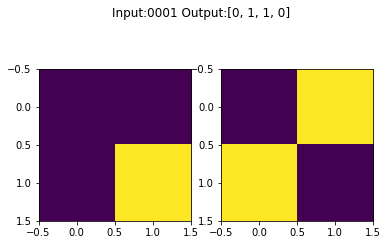

In [16]:
def get_image(i):
  inp="{:04b}".format(i)
  oup=get_z("{:04b}".format(i))
  tru = np.array([int(i) for i in inp]).reshape((2, 2))
  img = np.array(oup).reshape((2, 2))
  fig, ax = plt.subplots(ncols=2)
  fig.suptitle("Input:{} Output:{}".format(inp,oup))
  ax[0].imshow(tru)
  ax[1].imshow(img)
  plt.xticks=[0,1]
  plt.yticks=[1,0]

  plt.show()
get_image(1)

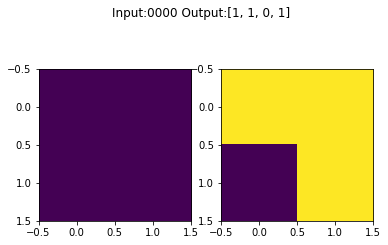

0


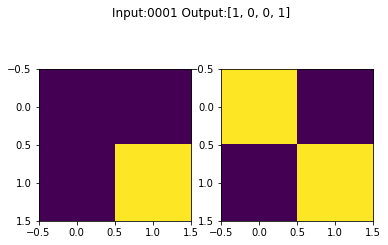

1


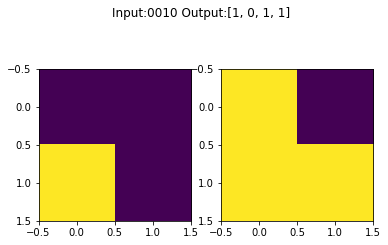

2


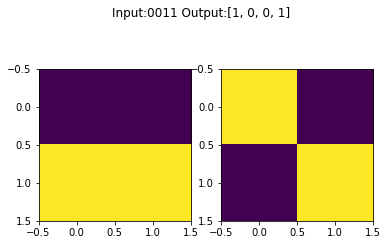

3


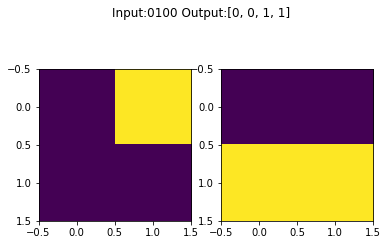

4


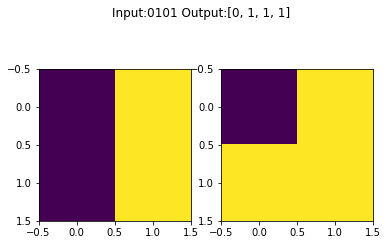

5


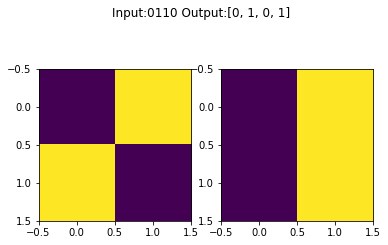

6


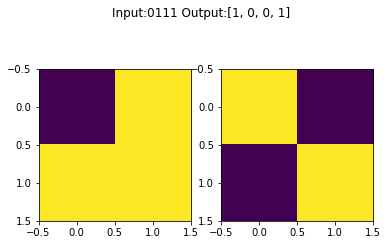

7


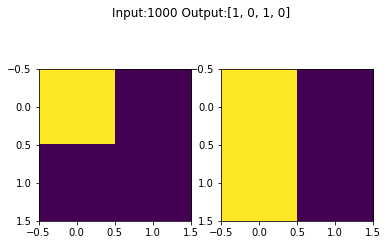

8


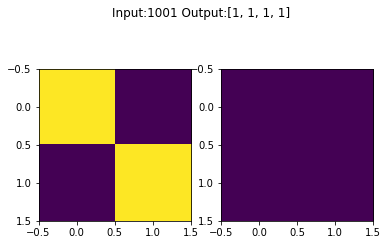

9


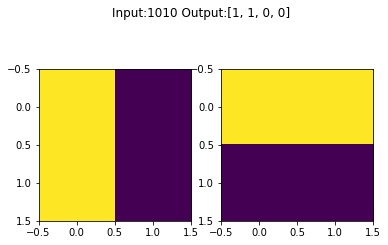

10


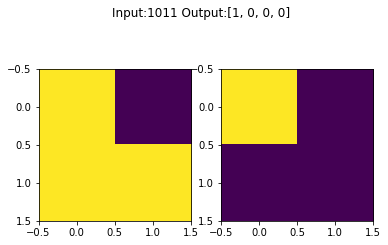

11


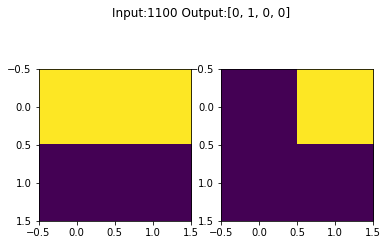

12


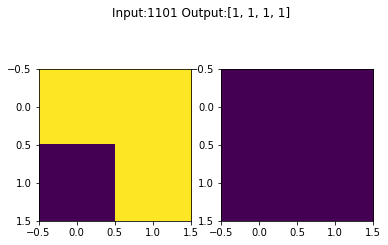

13


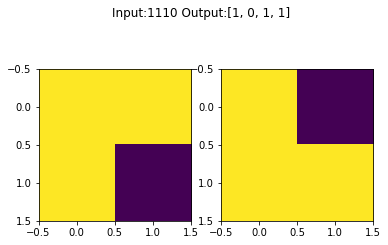

14


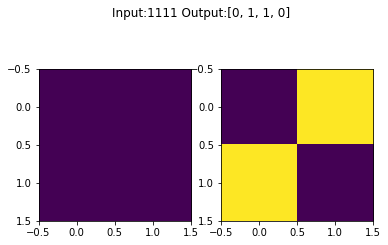

15


In [17]:
for i in range(16):
  get_image(i)
  print(i)